<a href="https://colab.research.google.com/github/Sudol67/MachineLearningEyeVeins/blob/main/DnoOkaV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Inicjalizacja bibliotek


*   cv2 - wczytywanie zdjęć
*   os -
*   numpy - obliczenia, macierze
*   sklearn - machine learning
*   PIL - obsługa rozszerzenia .tif

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

## Odczyt plików i zapis do słownika

Zdjęcia wejściowe znajdują się na dysku google. Dane zostały podzielone na dwa zbiory:
*   Before - zdjęcia dna oka przed obróbką
*   Manual - zdjęcia żył oka po ręcznej obróbce



In [ ]:
folder_path_before = '/content/drive/MyDrive/Colab Notebooks/Before'
folder_path_manual = '/content/drive/MyDrive/Colab Notebooks/Manual'

original_images = {}
manual_images = {}

for img_file in os.listdir(folder_path_before):
    if img_file.endswith(".jpg"):
        base_name = os.path.splitext(img_file)[0]
        image_path = os.path.join(folder_path_before, img_file)
        image = cv2.imread(image_path)
        if image is not None:
            original_images[base_name] = image
        else:
            print(f"Nie udało się wczytać obrazu {img_file} z folderu Before.")

for img_file in os.listdir(folder_path_manual):
    if img_file.endswith(".tif"):
        base_name = os.path.splitext(img_file)[0]
        image_path = os.path.join(folder_path_manual, img_file)
        pil_image = Image.open(image_path)
        image_array = np.array(pil_image)
        if image is not None:
            manual_images[base_name] = image_array
        else:
            print(f"Nie udało się wczytać obrazu {img_file} z folderu Manual.")

## Wstępna obróbka zdjęć
Tylko zdjęcia z folderu podlegają tej edycji. Dokonywane zmiany:
*   Konwersja na skalę szarości
*   Wyrównanie histogramu dla poprawy kontrastu
*   Wyostrzenie (do poprawy)





In [ ]:
processed_images_before = {}

for img_file, image in original_images.items():
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    equalized_image = cv2.equalizeHist(gray_image)
    sharpening_kernel = np.array([[-1, -1, -1],
                                  [-1,  9, -1],
                                  [-1, -1, -1]])
    sharpened_image = cv2.filter2D(equalized_image, -1, sharpening_kernel)
    processed_images_before[img_file] = sharpened_image

## Wyświetlanie wybranego obrazka po wstępnej edycji
Wyświetlanie korzysta z matplotlib. Wystarczy w wywołaniu funkcji podać nazwę żądanego pliku

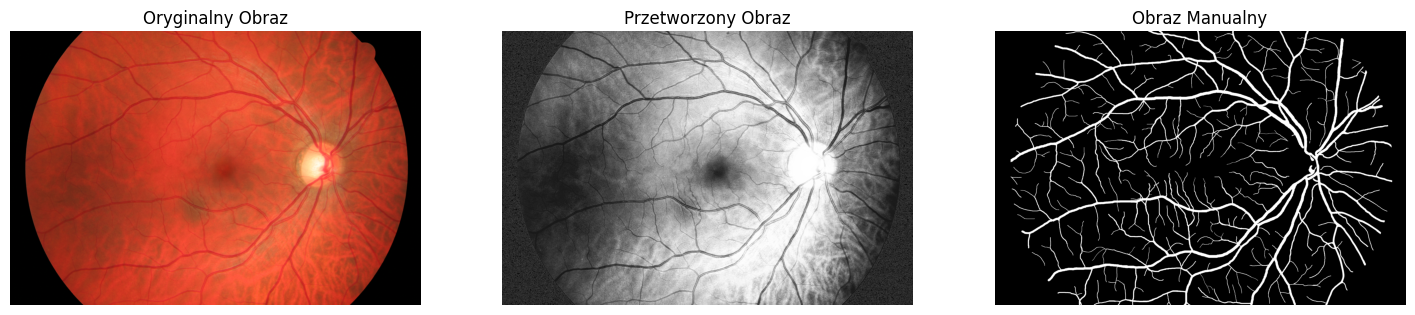

In [ ]:
def display_images(image_name):
    original_file = image_name
    manual_file = image_name

    if image_name in processed_images_before and original_file in original_images and manual_file in manual_images:
        plt.figure(figsize=(18, 6))

        plt.subplot(1, 3, 1)
        rgb_image = cv2.cvtColor(original_images[original_file], cv2.COLOR_BGR2RGB)
        plt.imshow(rgb_image)
        plt.title('Oryginalny Obraz')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(processed_images_before[image_name], cmap='gray')
        plt.title('Przetworzony Obraz')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(manual_images[manual_file], cmap='gray')
        plt.title('Obraz Manualny')
        plt.axis('off')

        plt.show()
    else:
        print("Nie ma takiego obrazu.")

display_images('01_h')

Tworzenie macierzy cech pikseli czyli tworzenie zbioru uczącego

In [ ]:
def calculate_features(image, x, y):
    pixel_value = image[x, y]
    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=5)[x, y]
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=5)[x, y] # gradient
    features = [pixel_value, sobelx, sobely]
    return features

In [ ]:
sampling_percentage = 0.001  # Procent pikseli do analizy

X = []  # lista cech pikseli dla wszystkich obrazów
labels = []  # naczynie czy nie

for img_file, processed_image in processed_images_before.items():
    manual_image = manual_images[img_file]
    num_pixels = processed_image.shape[0] * processed_image.shape[1]
    sample_size = int(num_pixels * sampling_percentage)  # Liczba pikseli do losowania
    print(sample_size)

    indices = np.random.choice(np.arange(num_pixels), size=sample_size, replace=False)
    for index in indices:
        clear_output(wait=True)
        # print(f'Obecnie przetwarzany piksel: {index} w pliku: {img_file}')
        x = index // processed_image.shape[1]
        y = index % processed_image.shape[1]

        features = calculate_features(processed_image, x, y)
        X.append(features)

        is_vein = manual_image[x, y] > 127
        labels.append(int(is_vein))

X = np.array(X)
y = np.array(labels).astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

818


In [ ]:
clf = DecisionTreeClassifier(random_state=42)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

In [ ]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.8484107579462102
Confusion Matrix:
[[2058  180]
 [ 192   24]]
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.92      0.92      2238
           1       0.12      0.11      0.11       216

    accuracy                           0.85      2454
   macro avg       0.52      0.52      0.52      2454
weighted avg       0.84      0.85      0.85      2454

